In [1]:
# Imports

# File handling
import os
#import pathlib
#from zipfile import ZipFile
#import splitfolders
import cv2
# Visualization
#import  matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline

# Data and maths
import numpy as np
import pandas as pd
#import random

# ML
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.optimizers import Adam
#from keras import models, layers
#from keras.utils import image_dataset_from_directory
#from keras.callbacks import CSVLogger

#from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def load_model(file="model18.h5", hist="18_history.csv"):
    
    # load model and history
    
    import tensorflow as tf
    import pandas as pd
    import numpy as np
    model = tf.keras.models.load_model(file)
    history = pd.read_csv(hist)[['loss','binary_accuracy', 'val_loss', 'val_binary_accuracy']]
    return model, history

def get_data(train_path='images/train/', test_path='images/test/', valid_path='images/val/', size=(256, 256), batch_size=1):
    
    # preprocess train, test and valid sets
    
    from keras.utils import image_dataset_from_directory
    train = image_dataset_from_directory(directory=train_path,
                             label_mode='binary',
                             color_mode="rgb",
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=True,
                             seed=77)
    test = image_dataset_from_directory(directory=test_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=False,
                             seed=77)
    valid = image_dataset_from_directory(directory=valid_path,
                             color_mode="rgb",
                             label_mode='binary',
                             image_size=size,
                             batch_size=batch_size,
                             shuffle=False,
                             seed=77)
    return train, test, valid

def evaluate_model(model, n, valid, test):
    
    pd.DataFrame(model.history.history).plot(figsize=(15,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(f'Model {n} Learning Curves')
    plt.show()
    print()
    print()
    print()
    print('Test set score')
    print()
    model.evaluate(test)
    print()
    print()
    print()
    print('Validation set score')
    print()
    model.evaluate(valid)

def dim_info(dimension):
    print("Dimension type: ", type(dimension))
    print("Dimension length: ", len(dimension))
    
def garson(A, B):
    # reference: https://csiu.github.io/blog/update/2017/03/29/day33.html
    """
    Computes Garson's algorithm
    A = matrix of weights of input-hidden layer (rows=input & cols=hidden)
    B = vector of weights of hidden-output layer
    """
    B = np.diag(B)

    # connection weight through the different hidden node
    cw = np.dot(A, B)
    cw = cw[1]
    # weight through node (axis=0 is column; sum per input feature)
    cw_h = abs(cw).sum(axis=0)

    # relative contribution of input neuron to outgoing signal of each hidden neuron
    # sum to find relative contribution of input neuron
    rc = np.divide(abs(cw), abs(cw_h))
    rc = rc.sum(axis=1)

    # normalize to 100% for relative importance
    ri = rc / rc.sum()
    return(ri)

def images_to_arrays(folder_path):
    X = []
    y = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if not os.path.isdir(class_path):
            continue
        class_label = class_folder  # Assign the class folder name as the label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (256, 256))  # Resize the image
                img_array = np.array(img, dtype=np.float32)  # Convert array values to float
                X.append(img_array)
                y.append(class_label)
    return np.array(X), np.array(y)

In [3]:
model, history = load_model()

In [10]:
X_train, y_train = images_to_arrays("images\\train")
X_test, y_test = images_to_arrays("images\\test")
X_valid, y_valid = images_to_arrays("images\\val")

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [14]:
logreg = LogisticRegression(max_iter=50)
logreg.fit(X_train_flat, y_train)
y_pred_logreg = logreg.predict(X_test_flat)
print("Logistic Regression Classifier accuracy: ", logreg.score(X_test_flat, y_test))

Logistic Regression Classifier accuracy:  0.8160377358490566


In [19]:
X_test.shape

(2120, 256, 256, 3)

In [15]:
logreg_sens_analysis_results = garson(X_test_flat, y_pred_logreg)

ValueError: shapes (2120,196608) and (2120,2120) not aligned: 196608 (dim 1) != 2120 (dim 0)

In [ ]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_flat, y_train)
y_pred_knn = knn.predict(X_test_flat)
accuracy = accuracy_score(y_test, y_pred_knn)
print("K-Nearest-Neighbour Classifier accuracy: ", accuracy)

In [ ]:
knn_sens_analysis_results = garson(X_test_flat, y_pred_knn)

### Data loading

In [ ]:
# image data
#splitfolders.ratio("data/images_unf/", output="images", seed=586, ratio=(.8, .1, .1), group_prefix=None, move=True)

In [2]:
# preprocess train, test and valid sets
train_path = 'images/train/'
test_path = 'images/test/'
valid_path = 'images/val/'
size = (256, 256)

train = image_dataset_from_directory(directory=train_path,
                         label_mode='binary',
                         color_mode="rgb",
                         image_size=size,
                         shuffle=True,
                         seed=77)

test = image_dataset_from_directory(directory=test_path,
                         color_mode="rgb",
                         label_mode='binary',
                         image_size=size,
                         shuffle=False,
                         seed=77)

valid = image_dataset_from_directory(directory=valid_path,
                         color_mode="rgb",
                         label_mode='binary',
                         image_size=size,
                         shuffle=False,
                         seed=77)

Found 16930 files belonging to 2 classes.
Found 2120 files belonging to 2 classes.
Found 2115 files belonging to 2 classes.


### Model building

In [13]:
def evaluate_model(model, n, val=valid, test=test):
    
    pd.DataFrame(model.history.history).plot(figsize=(15,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(f'Model {n} Learning Curves')
    plt.show()
    print()
    print()
    print()
    print('Test set score')
    print()
    model.evaluate(test)
    print()
    print()
    print()
    print('Validation set score')
    print()
    model.evaluate(valid)
    
def save_model(model, n):
    model.save(f"model{n}.h5")
    history = pd.DataFrame(model.history.history)
    hist_csv_file = f"model{n}_history.csv"
    with open(hist_csv_file, mode='w') as f:
        history.to_csv(f)    
# model = tf.keras.models.load_model("model.h5")

def train_model(model, n, epochs, patience=5):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    csv_logger = CSVLogger(f'model{n}_training.log')
    return model.fit(train, validation_data=valid, verbose=1, epochs=epochs, shuffle=True, callbacks=[early_stopping_cb, csv_logger])

## Model 16 output

In [30]:
model16 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, activation="softmax") # output
    ])

model16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model16.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

Epoch 1/50
530/530 [==============================] - 151s 284ms/step - loss: 1.1508 - accuracy: 0.7456 - val_loss: 0.5558 - val_accuracy: 0.7400
Epoch 2/50
530/530 [==============================] - 148s 279ms/step - loss: 0.5366 - accuracy: 0.7741 - val_loss: 0.4956 - val_accuracy: 0.8005
Epoch 3/50
530/530 [==============================] - 147s 277ms/step - loss: 0.5193 - accuracy: 0.7853 - val_loss: 0.4773 - val_accuracy: 0.8123
Epoch 4/50
530/530 [==============================] - 146s 274ms/step - loss: 0.5089 - accuracy: 0.7901 - val_loss: 0.4731 - val_accuracy: 0.8213
Epoch 5/50
530/530 [==============================] - 146s 276ms/step - loss: 0.5001 - accuracy: 0.7980 - val_loss: 0.4634 - val_accuracy: 0.8222
Epoch 6/50
530/530 [==============================] - 146s 275ms/step - loss: 0.4955 - accuracy: 0.7996 - val_loss: 0.4622 - val_accuracy: 0.8165
Epoch 7/50
530/530 [==============================] - 146s 275ms/step - loss: 0.4925 - accuracy: 0.8012 - val_loss: 0.4566 -

## Model 18 output -- Best

In [6]:
# preprocess train, test and valid sets
train_path = 'images/train/'
test_path = 'images/test/'
valid_path = 'images/val/'
size = (256, 256)

train = image_dataset_from_directory(directory=train_path,
                         labels='inferred',
                         label_mode='binary',
                         color_mode="rgb",
                         image_size=size,
                         shuffle=True,
                         seed=77)

test = image_dataset_from_directory(directory=test_path,
                         color_mode="rgb",
                         label_mode='binary',
                         image_size=size,
                         shuffle=False,
                         seed=77)

valid = image_dataset_from_directory(directory=valid_path,
                         color_mode="rgb",
                         label_mode='binary',
                         image_size=size,
                         shuffle=False,
                         seed=77)

shape = (256, 256, 3)
drop = 0.6
kernel = (3, 3)
pool = (2, 2)
num_classes=2
regularizer=keras.regularizers.l2(0.01)
learning_rate=0.0017

model18 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model18.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model18.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

Epoch 1/50
530/530 [==============================] - 146s 274ms/step - loss: 0.5872 - binary_accuracy: 0.7271 - val_loss: 0.4648 - val_binary_accuracy: 0.7948
Epoch 2/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4833 - binary_accuracy: 0.7856 - val_loss: 0.4433 - val_binary_accuracy: 0.8024
Epoch 3/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4585 - binary_accuracy: 0.8004 - val_loss: 0.4319 - val_binary_accuracy: 0.8076
Epoch 4/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4545 - binary_accuracy: 0.8058 - val_loss: 0.4077 - val_binary_accuracy: 0.8213
Epoch 5/50
530/530 [==============================] - 144s 272ms/step - loss: 0.4440 - binary_accuracy: 0.8108 - val_loss: 0.4301 - val_binary_accuracy: 0.8165
Epoch 6/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4358 - binary_accuracy: 0.8151 - val_loss: 0.4100 - val_binary_accuracy: 0.8265
Epoch 7/50
530/530 [====================

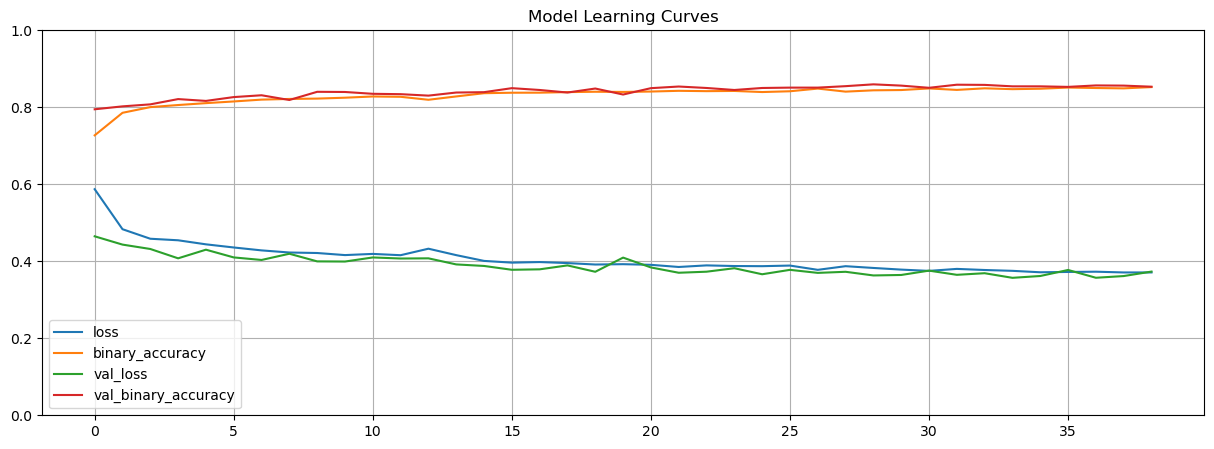




Test set score

67/67 [==============================] - 5s 75ms/step - loss: 0.3481 - binary_accuracy: 0.8656



Validation set score

67/67 [==============================] - 5s 74ms/step - loss: 0.3570 - binary_accuracy: 0.8544


In [76]:
evaluate_model(model18)

## Models

model 1: loss: 0.6931 - accuracy: 0.4816 - val_loss: 0.6931 - val_accuracy: 0.4818  

model 2: loss: 8.3040 - accuracy: 0.4834 (interrupted)  

model 3: loss: 7.7412 - accuracy: 0.5178 - val_loss: 7.7656 - val_accuracy: 0.5182 (interrupted)  

model 4: loss: 0.7825 - accuracy: 0.4816 - val_loss: 0.6931 - val_accuracy: 0.4818  

model 5: loss: 0.4360 - accuracy: 0.8014 - val_loss: 0.4345 - val_accuracy: 0.8052  

model 6: loss: 0.4879 - accuracy: 0.7790 - val_loss: 0.4714 - val_accuracy: 0.7721  

model 7: loss: 0.3973 - accuracy: 0.8236 - val_loss: 0.4227 - val_accuracy: 0.8132  

model 8: loss: 0.0499 - accuracy: 0.9820 - val_loss: 0.6409 - val_accuracy: 0.8771  

model 14: loss: 0.7177 - accuracy: 0.5157 - val_loss: 0.7177 - val_accuracy: 0.5182  

model15 : loss: 0.7157 - accuracy: 0.4834 (interrupted)  

model 16: loss: 0.4366 - accuracy: 0.8351 - val_loss: 0.4091 - val_accuracy: 0.8459 (50 epochs)  

model 17: loss: 0.5579 - accuracy: 0.7285 - val_loss: 0.5146 - val_accuracy: 0.7688 (2 epochs)  




$model$ $18$: loss: 0.3710 - binary_accuracy: 0.8525 - val_loss: 0.3732 - val_binary_accuracy: $0.8534$ (50 epochs) # increased learning rate, l2 regulariztion, binary classification  





model 19: loss: 0.5588 - binary_accuracy: 0.7324 - val_loss: 0.4958 - val_binary_accuracy: 0.7759 (2 epochs)  

model 20: loss: 0.7127 - binary_accuracy: 0.5910(interrupted)  

model 21: 

In [ ]:
model1 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(16, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model1.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model2.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model3.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=input_shape),
                         
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, kernel_size=(3,3), activation="relu"), # conv layer
        layers.MaxPooling2D(),
        
        layers.Flatten(), # Dimensionality reduction (feature map)
        layers.Dropout(0.5), # Output layer
        layers.Dense(num_classes) # fully connected layer
    ])

model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model5 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Flatten(),
        
        layers.Dense(300, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="sigmoid") # output
    ])

model5.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model6 = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Flatten(),
        
        layers.Dense(300, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax") # output
    ])

model6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model7 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Flatten(),
        
        layers.Dense(200, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),

        layers.Dense(100, activation="relu"), # layer
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax") # output
    ])

model7.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model8 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(2),
     
        layers.Conv2D(200, kernel_size=(3, 3), activation="relu"), # layer
        layers.MaxPooling2D(2),
        
        layers.Conv2D(150, kernel_size=(3, 3), activation="relu"), # layer
        layers.MaxPooling2D(2),

        layers.Conv2D(50, kernel_size=(3, 3), activation="relu"), # layer
        layers.MaxPooling2D(2),
        layers.Flatten(),
        
        layers.Dense(num_classes, activation="softmax") # output
    ])

model8.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model10 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(200, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(50, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes) # output
    ])

model10.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])#20 epochs

model14 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, actication="softmax") # output
    ])

model14.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model14.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model15 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        layers.Dropout(drop),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        layers.Dropout(drop),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes) # output
    ])

model15.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model15.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model16 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, activation="softmax") # output
    ])

model16.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model16.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model17 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Resizing(128, 128), # input
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(num_classes, activation="softmax") # output
    ])

model17.compile(optimizer=Adam(learning_rate=0.00164),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model17.summary()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model17.fit(train, validation_data=valid, verbose=1, epochs=2, shuffle=True, callbacks=[early_stopping_cb])

model18 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model18.compile(optimizer=Adam(learning_rate=0.0017),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model18.fit(train, validation_data=valid, verbose=1, epochs=50, shuffle=True, callbacks=[early_stopping_cb])

model19 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3)), # input
        layers.Resizing(128, 128),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model19.compile(optimizer=Adam(learning_rate=0.00164),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model20 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=(256, 256, 3), name='input'), # input
        layers.Resizing(128, 128),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu", name='layer1'), # layer
        layers.MaxPooling2D(pool_size=pool),
                
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu", name='layer2'), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.GlobalMaxPooling2D(name="global_maxpooling"),
        
        layers.Flatten(),
        
        layers.Dense(1, activation="sigmoid", name='output') # output
    ])
model20.compile(optimizer=Adam(learning_rate=0.0018),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [25]:
shape = (256, 256, 3)
drop = 0.6
kernel = (3, 3)
pool = (2, 2)
regularizer=keras.regularizers.l2(0.01)

model21 = keras.Sequential(
    [   
        layers.Rescaling(1./255, input_shape=shape), # input
        layers.Resizing(240, 240),
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(100, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        #layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        #layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
    ])

model21.compile(optimizer=Adam(learning_rate=0.00173),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

```
shape = (256, 256, 3)
drop = 0.6
kernel = (3, 3)
pool = (2, 2)
regularizer=keras.regularizers.l2(0.01)
learning_rate=0.0017
```

```
layers.Rescaling(1./255, input_shape=shape), # input
        layers.MaxPooling2D(pool_size=pool),
     
        layers.Conv2D(64, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),
        
        layers.Conv2D(32, kernel_size=kernel, kernel_regularizer=regularizer, activation="relu"), # layer
        layers.MaxPooling2D(pool_size=pool),

     
        layers.Flatten(),
        layers.Dropout(drop),     
        layers.Dense(1, activation="sigmoid") # output
```

In [ ]:
model21 = train_model(model21, 21, 70, patience=7) # layers.Resizing(240, 240), learning_rate=0.00173, 100 neurons
save_model(model21, 21)

In [ ]:
model21.save("model21.h5")

In [ ]:
Epoch 1/50
530/530 [==============================] - 146s 274ms/step - loss: 0.5872 - binary_accuracy: 0.7271 - val_loss: 0.4648 - val_binary_accuracy: 0.7948
Epoch 2/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4833 - binary_accuracy: 0.7856 - val_loss: 0.4433 - val_binary_accuracy: 0.8024
Epoch 3/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4585 - binary_accuracy: 0.8004 - val_loss: 0.4319 - val_binary_accuracy: 0.8076
Epoch 4/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4545 - binary_accuracy: 0.8058 - val_loss: 0.4077 - val_binary_accuracy: 0.8213
Epoch 5/50
530/530 [==============================] - 144s 272ms/step - loss: 0.4440 - binary_accuracy: 0.8108 - val_loss: 0.4301 - val_binary_accuracy: 0.8165
Epoch 6/50
530/530 [==============================] - 145s 272ms/step - loss: 0.4358 - binary_accuracy: 0.8151 - val_loss: 0.4100 - val_binary_accuracy: 0.8265
Epoch 7/50
530/530 [==============================] - 144s 272ms/step - loss: 0.4283 - binary_accuracy: 0.8199 - val_loss: 0.4034 - val_binary_accuracy: 0.8312
Epoch 8/50
530/530 [==============================] - 144s 271ms/step - loss: 0.4228 - binary_accuracy: 0.8216 - val_loss: 0.4196 - val_binary_accuracy: 0.8189
Epoch 9/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4215 - binary_accuracy: 0.8226 - val_loss: 0.3997 - val_binary_accuracy: 0.8402
Epoch 10/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4161 - binary_accuracy: 0.8249 - val_loss: 0.3993 - val_binary_accuracy: 0.8397
Epoch 11/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4192 - binary_accuracy: 0.8281 - val_loss: 0.4099 - val_binary_accuracy: 0.8350
Epoch 12/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4158 - binary_accuracy: 0.8272 - val_loss: 0.4072 - val_binary_accuracy: 0.8340
Epoch 13/50
530/530 [==============================] - 144s 272ms/step - loss: 0.4327 - binary_accuracy: 0.8195 - val_loss: 0.4076 - val_binary_accuracy: 0.8303
Epoch 14/50
530/530 [==============================] - 145s 273ms/step - loss: 0.4160 - binary_accuracy: 0.8282 - val_loss: 0.3918 - val_binary_accuracy: 0.8383
Epoch 15/50
530/530 [==============================] - 146s 275ms/step - loss: 0.4010 - binary_accuracy: 0.8366 - val_loss: 0.3879 - val_binary_accuracy: 0.8392
Epoch 16/50
530/530 [==============================] - 145s 273ms/step - loss: 0.3965 - binary_accuracy: 0.8378 - val_loss: 0.3779 - val_binary_accuracy: 0.8496
Epoch 17/50
530/530 [==============================] - 144s 272ms/step - loss: 0.3980 - binary_accuracy: 0.8379 - val_loss: 0.3791 - val_binary_accuracy: 0.8449
Epoch 18/50
530/530 [==============================] - 144s 271ms/step - loss: 0.3953 - binary_accuracy: 0.8394 - val_loss: 0.3893 - val_binary_accuracy: 0.8383
Epoch 19/50
530/530 [==============================] - 144s 271ms/step - loss: 0.3916 - binary_accuracy: 0.8403 - val_loss: 0.3727 - val_binary_accuracy: 0.8487
Epoch 20/50
530/530 [==============================] - 144s 271ms/step - loss: 0.3925 - binary_accuracy: 0.8399 - val_loss: 0.4095 - val_binary_accuracy: 0.8331
Epoch 21/50
530/530 [==============================] - 144s 272ms/step - loss: 0.3908 - binary_accuracy: 0.8409 - val_loss: 0.3840 - val_binary_accuracy: 0.8496
Epoch 22/50
530/530 [==============================] - 143s 269ms/step - loss: 0.3852 - binary_accuracy: 0.8428 - val_loss: 0.3702 - val_binary_accuracy: 0.8539
Epoch 23/50
530/530 [==============================] - 143s 270ms/step - loss: 0.3893 - binary_accuracy: 0.8419 - val_loss: 0.3729 - val_binary_accuracy: 0.8501
Epoch 24/50
530/530 [==============================] - 144s 271ms/step - loss: 0.3877 - binary_accuracy: 0.8424 - val_loss: 0.3819 - val_binary_accuracy: 0.8449
Epoch 25/50
530/530 [==============================] - 143s 269ms/step - loss: 0.3873 - binary_accuracy: 0.8396 - val_loss: 0.3663 - val_binary_accuracy: 0.8501
Epoch 26/50
530/530 [==============================] - 143s 270ms/step - loss: 0.3889 - binary_accuracy: 0.8416 - val_loss: 0.3777 - val_binary_accuracy: 0.8511
Epoch 27/50
530/530 [==============================] - 143s 270ms/step - loss: 0.3778 - binary_accuracy: 0.8486 - val_loss: 0.3699 - val_binary_accuracy: 0.8511
Epoch 28/50
530/530 [==============================] - 145s 273ms/step - loss: 0.3872 - binary_accuracy: 0.8406 - val_loss: 0.3727 - val_binary_accuracy: 0.8548
Epoch 29/50
530/530 [==============================] - 145s 273ms/step - loss: 0.3827 - binary_accuracy: 0.8441 - val_loss: 0.3632 - val_binary_accuracy: 0.8596
Epoch 30/50
530/530 [==============================] - 146s 275ms/step - loss: 0.3784 - binary_accuracy: 0.8448 - val_loss: 0.3644 - val_binary_accuracy: 0.8563
Epoch 31/50
530/530 [==============================] - 147s 277ms/step - loss: 0.3750 - binary_accuracy: 0.8490 - val_loss: 0.3757 - val_binary_accuracy: 0.8506
Epoch 32/50
530/530 [==============================] - 148s 279ms/step - loss: 0.3802 - binary_accuracy: 0.8451 - val_loss: 0.3648 - val_binary_accuracy: 0.8586
Epoch 33/50
530/530 [==============================] - 146s 274ms/step - loss: 0.3774 - binary_accuracy: 0.8493 - val_loss: 0.3690 - val_binary_accuracy: 0.8582
Epoch 34/50
530/530 [==============================] - 146s 276ms/step - loss: 0.3752 - binary_accuracy: 0.8471 - val_loss: 0.3570 - val_binary_accuracy: 0.8544
Epoch 35/50
530/530 [==============================] - 150s 282ms/step - loss: 0.3714 - binary_accuracy: 0.8481 - val_loss: 0.3618 - val_binary_accuracy: 0.8544
Epoch 36/50
530/530 [==============================] - 144s 271ms/step - loss: 0.3723 - binary_accuracy: 0.8513 - val_loss: 0.3774 - val_binary_accuracy: 0.8530
Epoch 37/50
530/530 [==============================] - 142s 268ms/step - loss: 0.3729 - binary_accuracy: 0.8500 - val_loss: 0.3572 - val_binary_accuracy: 0.8567
Epoch 38/50
530/530 [==============================] - 144s 271ms/step - loss: 0.3710 - binary_accuracy: 0.8491 - val_loss: 0.3616 - val_binary_accuracy: 0.8563
Epoch 39/50
530/530 [==============================] - 145s 273ms/step - loss: 0.3710 - binary_accuracy: 0.8525 - val_loss: 0.3732 - val_binary_accuracy: 0.8534